In [80]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.read_csv('capacitor_discharging.csv')
df_charging = pd.read_csv('capacitor_charging.csv')

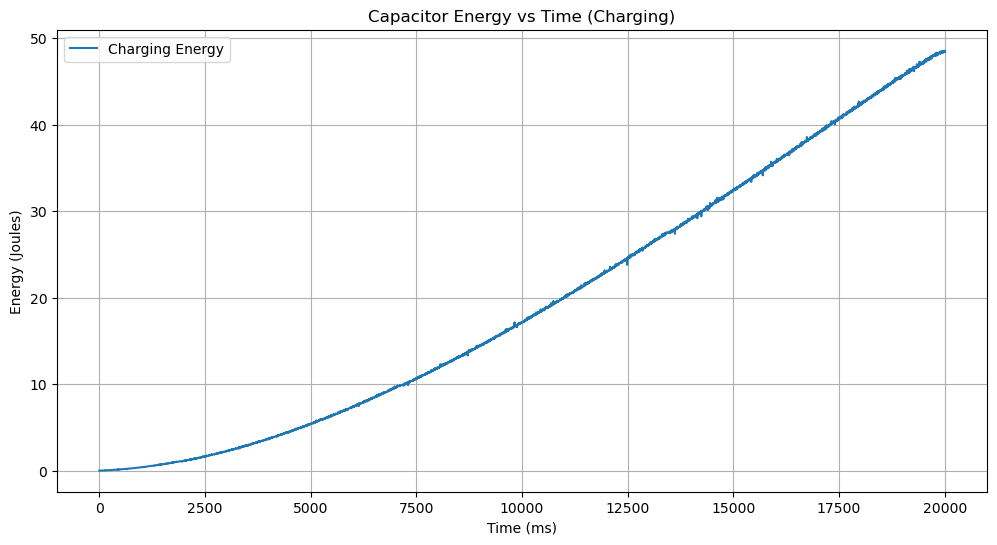

In [81]:
df_charging_clean = df_charging[df_charging.columns[0]].str.split('\t', expand=True)
df_charging_clean.columns = ['time_ms', 'voltage_Va', 'voltage_Vb', 'current_A', 'power_W']
df_charging_clean = df_charging_clean.apply(pd.to_numeric)

df_charging_clean['energy_Vb'] = 0.25 * df_charging_clean['voltage_Vb']**2

plt.figure(figsize=(12, 6))
plt.plot(df_charging_clean['time_ms'], df_charging_clean['energy_Vb'], label='Charging Energy')
plt.xlabel('Time (ms)')
plt.ylabel('Energy (Joules)')
plt.title('Capacitor Energy vs Time (Charging)')
plt.legend()
plt.grid(True)
plt.show()

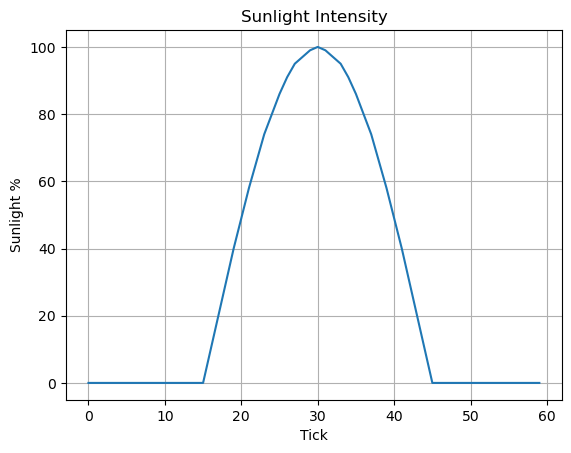

In [82]:
import math
yesterday_url = BASE_URL + ENDPOINTS["yesterday"]
response = requests.get(yesterday_url)
yesterday_data = response.json()

df = pd.DataFrame(yesterday_data)
ticks = df['tick'].tolist()
sun_values = []
for t in ticks:
    SUNRISE = 15
    DAY_LENGTH = 30
    if t < SUNRISE:
        sun = 0
    elif t < SUNRISE + DAY_LENGTH:
        sun = int(math.sin((t-SUNRISE)*math.pi/DAY_LENGTH)*100)
    else:
        sun = 0
    sun_values.append(sun)
df['sun'] = sun_values

df.plot(x='tick', y='sun', kind='line', legend=False)
plt.title('Sunlight Intensity')
plt.xlabel('Tick')
plt.ylabel('Sunlight %')
plt.grid(True)
plt.show()

#sunlight doesn't depend on ticks, so the grpah always gonna look like this:

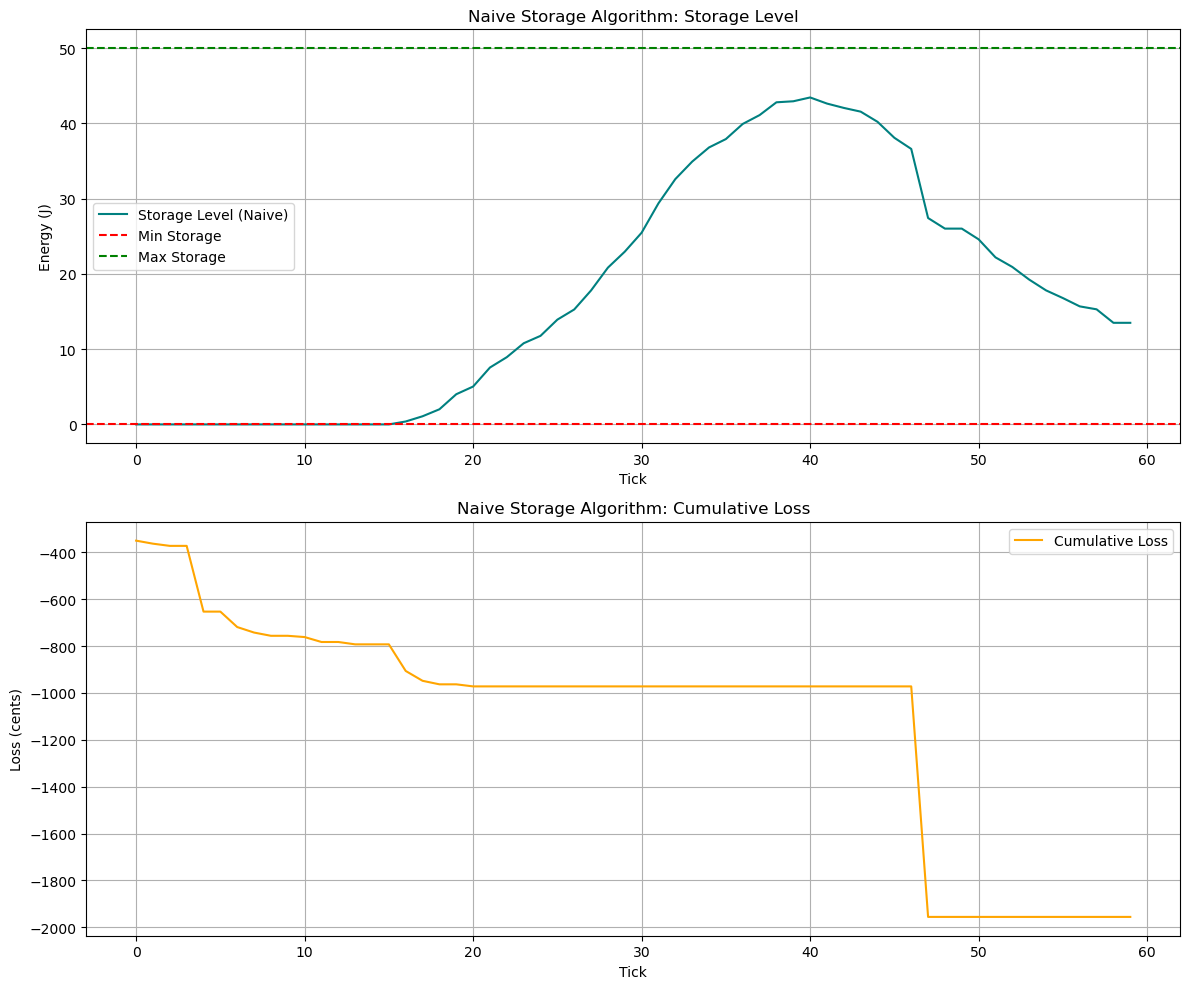

Final loss (naive): 1955.63 cents
Number of buy actions: 15


In [83]:
import numpy as np

def run_naive_storage_algorithm(df, defer_df):
    """
    Naive storage algorithm with exponential charging and discharging:
    Charging: E(t) = A * (1 - exp(-t/τ))
    Discharging: E(t) = E_initial * exp(-t/τ)
    """
    MAX_STORAGE = 50
    MIN_STORAGE = 0
    CHARGE_TAU = 4  # time constant for charging - should be 1.3 if it takes 4 ticks to charge to full storage, but 4 is more realistic and gives leeway. adjust if needed pls
    DISCHARGE_TAU = 4
    DT = 1  # tick duration

    storage = [0]
    actions = []
    profit = 0
    profit_over_time = []

    for i in range(len(df)):
        tick = df['tick'][i]
        sell_price = df.iloc[i]['sell_price']
        buy_price = sell_price * 0.5
        demand = df['demand'][i]
        sun = df['sun'][i]
        current_storage = storage[-1]

        # 1. Solar charging (exponential approach to MAX_STORAGE)
        if sun > 0:
            solar_energy = sun * 0.01 * 5
            charge_possible = (MAX_STORAGE - current_storage) * (1 - np.exp(-DT / CHARGE_TAU))
            actual_charge = min(solar_energy, charge_possible)
            current_storage += actual_charge
            actions.append(f'solar_charge_{actual_charge:.2f}J')

        # 2. Discharge for demand (exponential decay from current storage)
        if demand > 0:
            # Exponential discharge: E(t) = E_initial * exp(-t/τ)
            # Energy delivered in this tick:
            e_initial = current_storage
            e_final = e_initial * np.exp(-DT / DISCHARGE_TAU)
            discharge_possible = e_initial - e_final
            used_from_storage = min(demand, discharge_possible)
            current_storage -= used_from_storage
            actions.append(f'discharge_{used_from_storage:.2f}J')
            if used_from_storage < demand:
                grid_energy = demand - used_from_storage
                profit -= grid_energy * buy_price
                actions.append(f'buy_{grid_energy:.2f}J')

        # 3. Deferable demands at their start tick
        active_deferables = defer_df[defer_df['start'] == tick]
        for _, row in active_deferables.iterrows():
            energy = row['energy']
            e_initial = current_storage
            e_final = e_initial * np.exp(-DT / DISCHARGE_TAU)
            discharge_possible = e_initial - e_final
            used_from_storage = min(energy, discharge_possible)
            current_storage -= used_from_storage
            actions.append(f'discharge_defer_{used_from_storage:.2f}J')
            if used_from_storage < energy:
                grid_energy = energy - used_from_storage
                profit -= grid_energy * buy_price
                actions.append(f'buy_defer_{grid_energy:.2f}J')

        # 4. Emergency buy if storage below MIN_STORAGE
        if current_storage < MIN_STORAGE:
            buy_amt = MIN_STORAGE - current_storage
            current_storage += buy_amt
            profit -= buy_amt * buy_price
            actions.append(f'emergency_buy_{buy_amt:.2f}J')

        current_storage = max(MIN_STORAGE, min(current_storage, MAX_STORAGE))
        storage.append(current_storage)
        profit_over_time.append(profit)

    return storage[1:], profit_over_time, actions

storage_naive, profit_naive, actions_naive = run_naive_storage_algorithm(df, defer_df)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

ax1.plot(df['tick'], storage_naive, label='Storage Level (Naive)', color='teal')
ax1.axhline(y=MIN_STORAGE, color='r', linestyle='--', label='Min Storage')
ax1.axhline(y=MAX_STORAGE, color='g', linestyle='--', label='Max Storage')
ax1.set_title('Naive Storage Algorithm: Storage Level')
ax1.set_xlabel('Tick')
ax1.set_ylabel('Energy (J)')
ax1.legend()
ax1.grid(True)

ax2.plot(df['tick'], profit_naive, color='orange', label='Cumulative Loss')
ax2.set_title('Naive Storage Algorithm: Cumulative Loss')
ax2.set_xlabel('Tick')
ax2.set_ylabel('Loss (cents)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Final loss (naive): {-profit_naive[-1]:.2f} cents")
print(f"Number of buy actions: {sum('buy' in a for a in actions_naive)}")

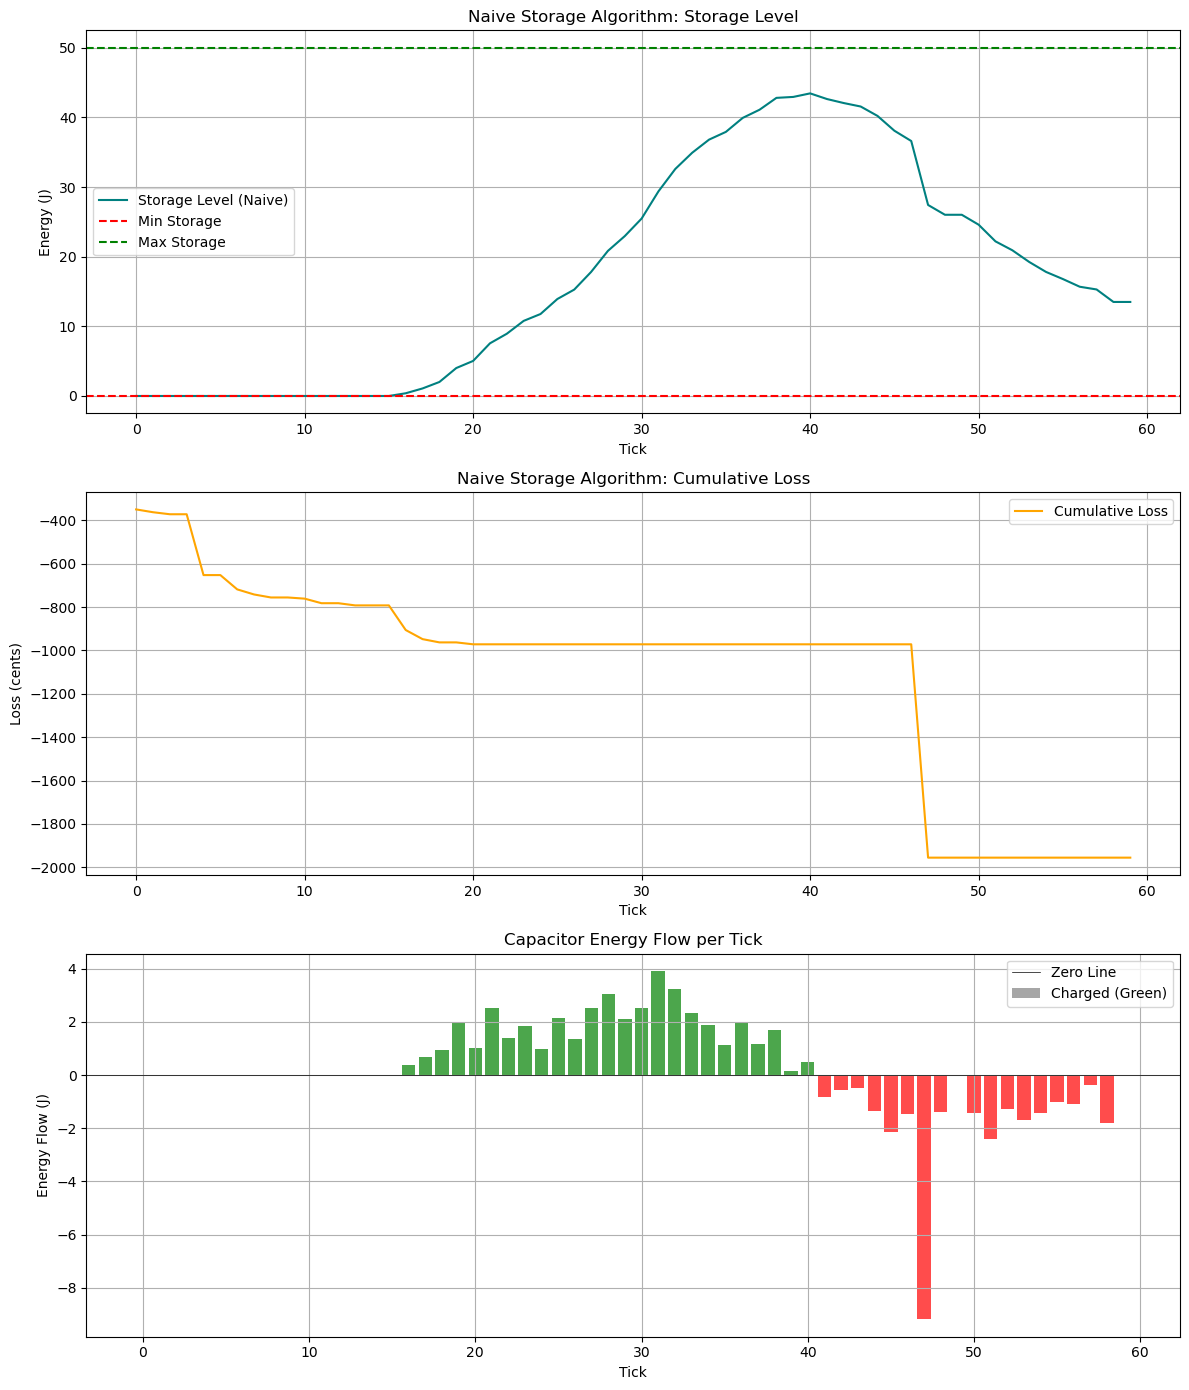

Final loss (naive): 1955.63 cents
Number of buy actions: 15
Total net energy flow: 13.50 J
Ticks with charging: 25
Ticks with discharging: 17
Ticks with no change: 18

Capacitor activity by tick:
Tick 1: nothing
Tick 2: nothing
Tick 3: nothing
Tick 4: nothing
Tick 5: nothing
Tick 6: nothing
Tick 7: nothing
Tick 8: nothing
Tick 9: nothing
Tick 10: nothing
Tick 11: nothing
Tick 12: nothing
Tick 13: nothing
Tick 14: nothing
Tick 15: nothing
Tick 16: nothing
Tick 17: charged 0.39 J
Tick 18: charged 0.69 J
Tick 19: charged 0.93 J
Tick 20: charged 2.00 J
Tick 21: charged 1.02 J
Tick 22: charged 2.53 J
Tick 23: charged 1.38 J
Tick 24: charged 1.85 J
Tick 25: charged 0.99 J
Tick 26: charged 2.15 J
Tick 27: charged 1.35 J
Tick 28: charged 2.53 J
Tick 29: charged 3.03 J
Tick 30: charged 2.12 J
Tick 31: charged 2.52 J
Tick 32: charged 3.91 J
Tick 33: charged 3.22 J
Tick 34: charged 2.32 J
Tick 35: charged 1.88 J
Tick 36: charged 1.11 J
Tick 37: charged 2.01 J
Tick 38: charged 1.17 J
Tick 39: char

In [ ]:
import numpy as np

def run_naive_storage_algorithm(df, defer_df):
    """
    Naive storage algorithm with exponential charging and discharging:
    Charging: E(t) = A * (1 - exp(-t/τ))
    Discharging: E(t) = E_initial * exp(-t/τ)
    """
    MAX_STORAGE = 50
    MIN_STORAGE = 0
    CHARGE_TAU = 4  # time constant for charging - should be 1.3 if it takes 4 ticks to charge to full storage, but 4 is more realistic and gives leeway. adjust if needed pls
    DISCHARGE_TAU = 4
    DT = 1  # tick duration

    storage = [0]
    actions = []
    profit = 0
    profit_over_time = []
    
    # Track net energy flow each tick
    capacitor_flow = []  # Net energy flow: positive = charged, negative = discharged, 0 = nothing
    flow_descriptions = []  # Description of what happened each tick

    for i in range(len(df)):
        tick = df['tick'][i]
        sell_price = df.iloc[i]['sell_price']
        buy_price = sell_price * 0.5
        demand = df['demand'][i]
        sun = df['sun'][i]
        current_storage = storage[-1]
        initial_storage = current_storage
        
        # 1. Solar charging (exponential approach to MAX_STORAGE)
        if sun > 0:
            solar_energy = sun * 0.01 * 5
            charge_possible = (MAX_STORAGE - current_storage) * (1 - np.exp(-DT / CHARGE_TAU))
            actual_charge = min(solar_energy, charge_possible)
            current_storage += actual_charge
            actions.append(f'solar_charge_{actual_charge:.2f}J')

        # 2. Discharge for demand (exponential decay from current storage)
        if demand > 0:
            # Exponential discharge: E(t) = E_initial * exp(-t/τ)
            # Energy delivered in this tick:
            e_initial = current_storage
            e_final = e_initial * np.exp(-DT / DISCHARGE_TAU)
            discharge_possible = e_initial - e_final
            used_from_storage = min(demand, discharge_possible)
            current_storage -= used_from_storage
            actions.append(f'discharge_{used_from_storage:.2f}J')
            if used_from_storage < demand:
                grid_energy = demand - used_from_storage
                profit -= grid_energy * buy_price
                actions.append(f'buy_{grid_energy:.2f}J')

        # 3. Deferable demands at their start tick
        active_deferables = defer_df[defer_df['start'] == tick]
        for _, row in active_deferables.iterrows():
            energy = row['energy']
            e_initial = current_storage
            e_final = e_initial * np.exp(-DT / DISCHARGE_TAU)
            discharge_possible = e_initial - e_final
            used_from_storage = min(energy, discharge_possible)
            current_storage -= used_from_storage
            actions.append(f'discharge_defer_{used_from_storage:.2f}J')
            if used_from_storage < energy:
                grid_energy = energy - used_from_storage
                profit -= grid_energy * buy_price
                actions.append(f'buy_defer_{grid_energy:.2f}J')

        net_flow = current_storage - initial_storage
        capacitor_flow.append(net_flow)
        
        if abs(net_flow) < 0.01: 
            flow_descriptions.append("nothing")
        elif net_flow > 0:
            flow_descriptions.append(f"charged {net_flow:.2f} J")
        else:
            flow_descriptions.append(f"discharged {abs(net_flow):.2f} J")

        current_storage = max(MIN_STORAGE, min(current_storage, MAX_STORAGE))
        storage.append(current_storage)
        profit_over_time.append(profit)

    return storage[1:], profit_over_time, actions, capacitor_flow, flow_descriptions

storage_naive, profit_naive, actions_naive, flow_naive, descriptions_naive = run_naive_storage_algorithm(df, defer_df)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 14))

# Storage level plot
ax1.plot(df['tick'], storage_naive, label='Storage Level (Naive)', color='teal')
ax1.axhline(y=MIN_STORAGE, color='r', linestyle='--', label='Min Storage')
ax1.axhline(y=MAX_STORAGE, color='g', linestyle='--', label='Max Storage')
ax1.set_title('Naive Storage Algorithm: Storage Level')
ax1.set_xlabel('Tick')
ax1.set_ylabel('Energy (J)')
ax1.legend()
ax1.grid(True)

# Cumulative profit plot
ax2.plot(df['tick'], profit_naive, color='orange', label='Cumulative Loss')
ax2.set_title('Naive Storage Algorithm: Cumulative Loss')
ax2.set_xlabel('Tick')
ax2.set_ylabel('Loss (cents)')
ax2.legend()
ax2.grid(True)

# Energy flow plot
colors = ['gray' if abs(f) < 0.01 else 'green' if f > 0 else 'red' for f in flow_naive]
ax3.bar(df['tick'], flow_naive, alpha=0.7, color=colors, width=0.8)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax3.set_title('Capacitor Energy Flow per Tick')
ax3.set_xlabel('Tick')
ax3.set_ylabel('Energy Flow (J)')
ax3.legend(['Zero Line', 'Charged (Green)', 'Discharged (Red)', 'No Change (Gray)'])
ax3.grid(True)

plt.tight_layout()
plt.show()

print(f"Final loss (naive): {-profit_naive[-1]:.2f} cents")
print(f"Number of buy actions: {sum('buy' in a for a in actions_naive)}")
print(f"Total net energy flow: {sum(flow_naive):.2f} J")
print(f"Ticks with charging: {sum(1 for f in flow_naive if f > 0.01)}")
print(f"Ticks with discharging: {sum(1 for f in flow_naive if f < -0.01)}")
print(f"Ticks with no change: {sum(1 for f in flow_naive if abs(f) <= 0.01)}")

print("\nCapacitor activity by tick:")
for i, desc in enumerate(descriptions_naive):
    print(f"Tick {i+1}: {desc}")

In [75]:
# Assuming you want to do this for the realistic storage algorithm (from cell 3)
# We'll print a summary of actions for each tick in a readable format

storage_real, profit_real, actions_real = run_realistic_storage_algorithm(df, defer_df)

for tick, action in enumerate(actions_real, start=1):
    # Split multiple actions in a tick (if any)
    if isinstance(action, list):
        action_str = "; ".join(action)
    else:
        action_str = action
    print(f"Tick {tick}: {action_str}")

Tick 1: discharge_defer_0.00J
Tick 2: buy_defer_50.00J
Tick 3: discharge_0.00J
Tick 4: buy_0.92J
Tick 5: discharge_0.00J
Tick 6: buy_0.64J
Tick 7: discharge_0.00J
Tick 8: buy_0.41J
Tick 9: discharge_defer_0.00J
Tick 10: buy_defer_28.05J
Tick 11: discharge_0.00J
Tick 12: buy_2.06J
Tick 13: discharge_0.00J
Tick 14: buy_0.22J
Tick 15: discharge_0.00J
Tick 16: buy_0.52J
Tick 17: discharge_0.00J
Tick 18: buy_0.82J
Tick 19: discharge_0.00J
Tick 20: buy_0.77J
Tick 21: discharge_0.00J
Tick 22: buy_1.85J
Tick 23: discharge_0.00J
Tick 24: buy_1.86J
Tick 25: discharge_0.00J
Tick 26: buy_0.38J
Tick 27: solar_charge_0.50J
Tick 28: discharge_0.14J
Tick 29: buy_2.12J
Tick 30: solar_charge_1.00J
Tick 31: discharge_0.39J
Tick 32: buy_1.86J
Tick 33: solar_charge_1.50J
Tick 34: discharge_0.70J
Tick 35: buy_0.25J
Tick 36: solar_charge_2.00J
Tick 37: discharge_1.07J
Tick 38: buy_2.60J
Tick 39: solar_charge_2.45J
Tick 40: discharge_1.46J
Tick 41: buy_1.42J
Tick 42: solar_charge_2.90J
Tick 43: discharge_1.87

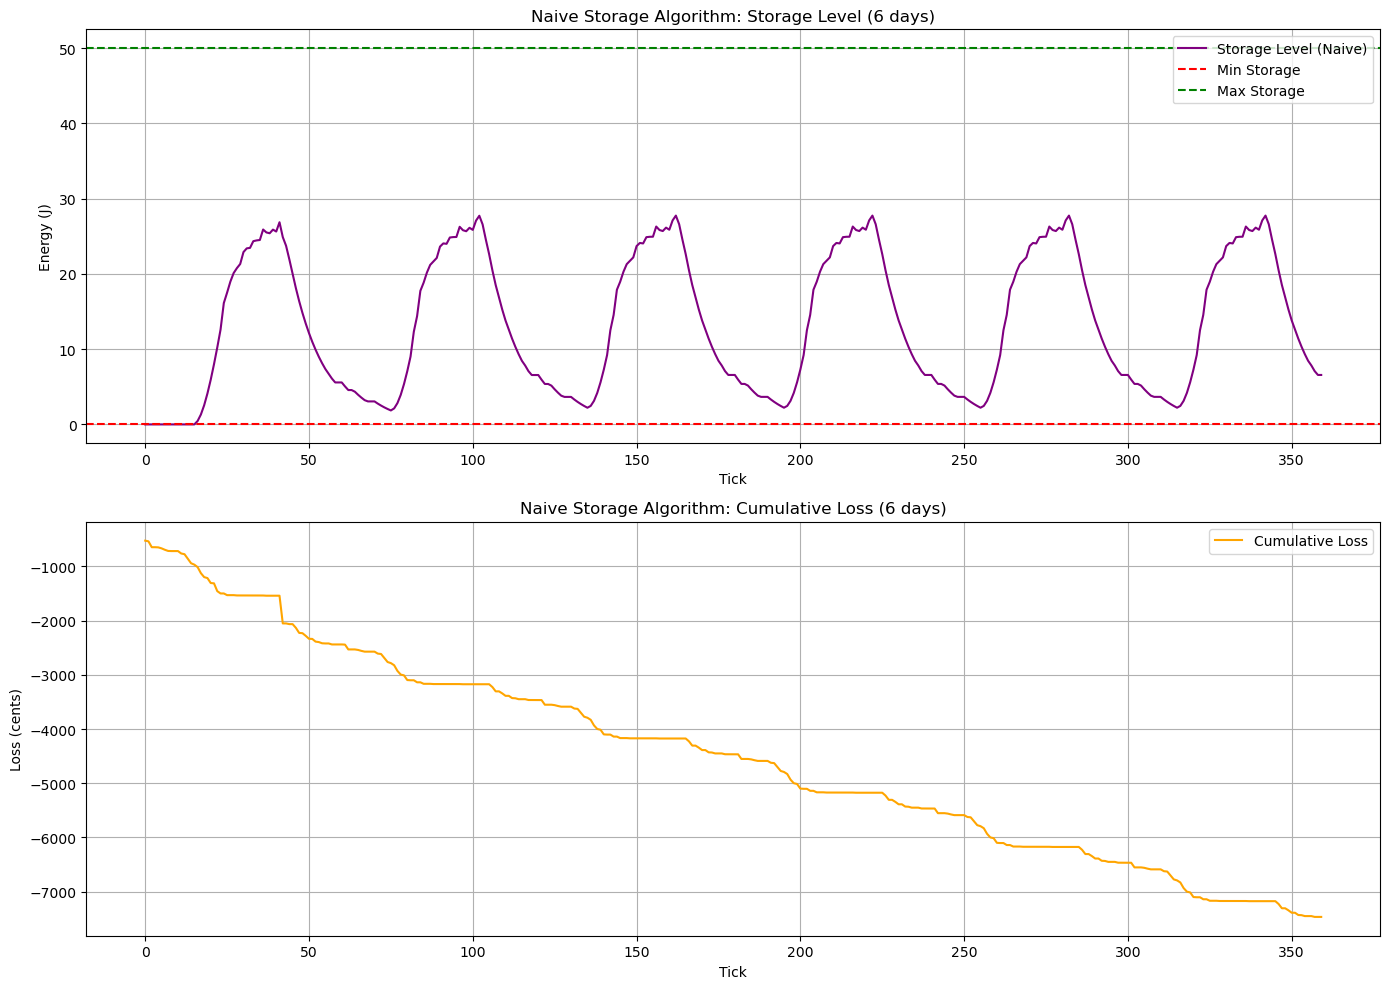

Final loss (naive, 6 days): 7464.80 cents
Final storage after 6 days: 6.57 J
Number of buy actions: 183


In [24]:
# Run simulation with cumulative profit over all days
storage_long = []
profit_long = []
actions_long = []
initial_storage = 0
profit = 0  # Accumulate profit across all days

for day in range(num_days):
    start_idx = day * ticks_per_day
    end_idx = (day + 1) * ticks_per_day
    df_day = df_long.iloc[start_idx:end_idx].reset_index(drop=True)
    defer_df_day = defer_df_long[(defer_df_long['start'] >= start_idx) & (defer_df_long['start'] < end_idx)].copy()
    defer_df_day['start'] -= start_idx
    defer_df_day['end'] -= start_idx

    # Pass profit into the function and return updated profit
    s, p, a = run_realistic_storage_algorithm_long(df_day, defer_df_day, initial_storage)
    # Offset profit for this day by current cumulative profit
    p = [x + profit for x in p]
    profit = p[-1]  # Update cumulative profit

    storage_long.extend(s)
    profit_long.extend(p)
    actions_long.extend(a)
    initial_storage = s[-1]

# Plot results (same as before)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

ax1.plot(range(total_ticks), storage_long, label='Storage Level (Naive)', color='purple')
ax1.axhline(y=MIN_STORAGE, color='r', linestyle='--', label='Min Storage')
ax1.axhline(y=MAX_STORAGE, color='g', linestyle='--', label='Max Storage')
ax1.set_title('Naive Storage Algorithm: Storage Level (6 days)')
ax1.set_xlabel('Tick')
ax1.set_ylabel('Energy (J)')
ax1.legend()
ax1.grid(True)

ax2.plot(range(total_ticks), profit_long, color='orange', label='Cumulative Loss')
ax2.set_title('Naive Storage Algorithm: Cumulative Loss (6 days)')
ax2.set_xlabel('Tick')
ax2.set_ylabel('Loss (cents)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Final loss (naive, 6 days): {-profit_long[-1]:.2f} cents")
print(f"Final storage after 6 days: {storage_long[-1]:.2f} J")
print(f"Number of buy actions: {sum('buy' in a for a in actions_long)}")


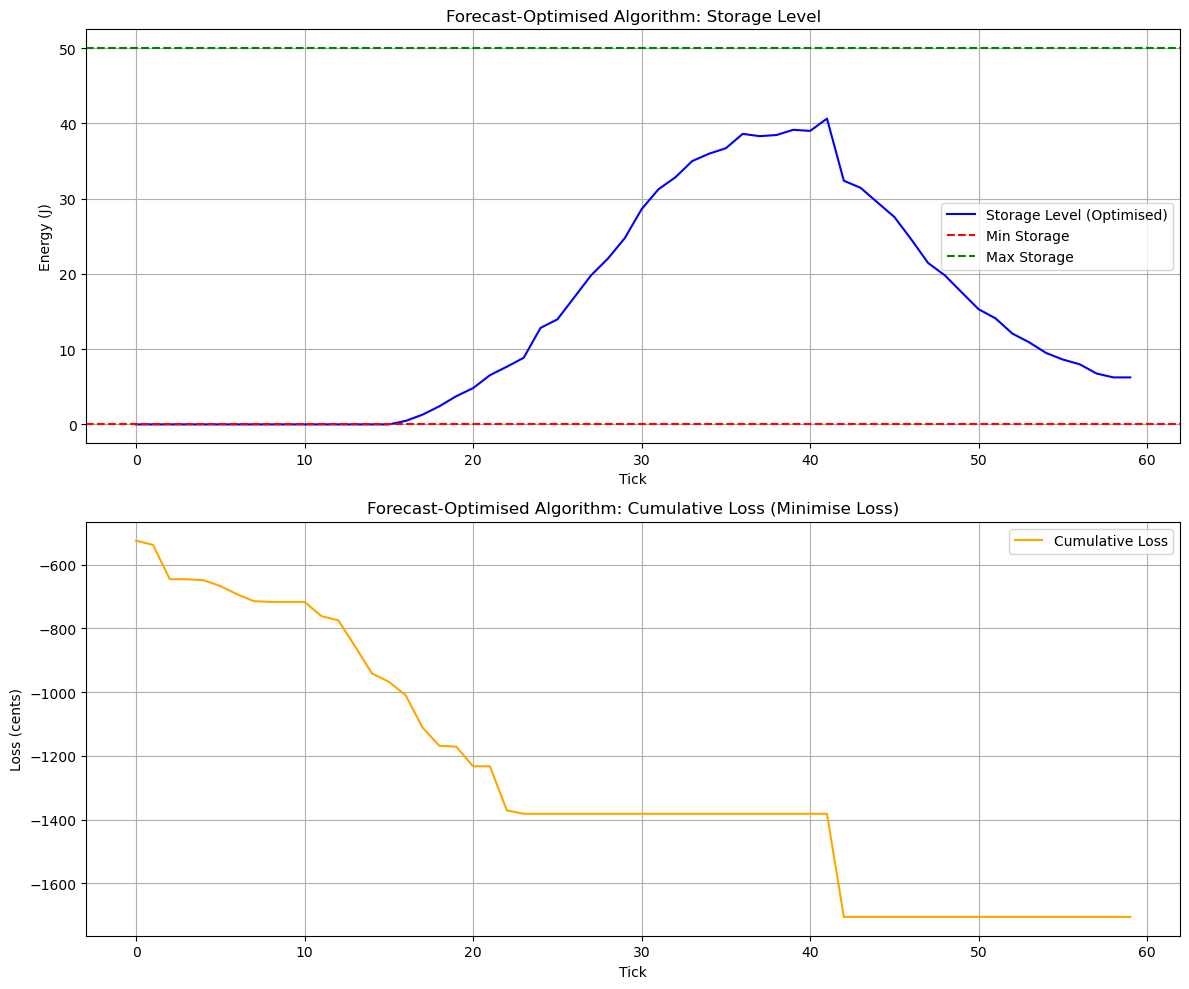

Final loss (optimised): 1705.37 cents
Number of buy actions: 21


In [36]:
def run_optimised_storage_algorithm(df, defer_df, window=10):
    """
    Optimised storage algorithm using a moving average forecast for sunlight and demand.
    Improves upon the naive algorithm by anticipating future solar and demand.
    """
    MAX_STORAGE = 50
    MIN_STORAGE = 0
    CHARGE_TAU = 4
    DISCHARGE_TAU = 4
    DT = 1

    storage = [0]
    actions = []
    profit = 0
    profit_over_time = []

    # Compute moving averages for sun and demand
    sun_forecast = df['sun'].rolling(window, min_periods=1).mean().shift(-window//2).fillna(method='bfill').fillna(method='ffill')
    demand_forecast = df['demand'].rolling(window, min_periods=1).mean().shift(-window//2).fillna(method='bfill').fillna(method='ffill')

    for i in range(len(df)):
        tick = df['tick'][i]
        sell_price = df.iloc[i]['sell_price']
        buy_price = sell_price * 0.5
        demand = df['demand'][i]
        sun = df['sun'][i]
        current_storage = storage[-1]

        # Forecasted sun and demand for next window
        future_sun = sun_forecast.iloc[i]
        future_demand = demand_forecast.iloc[i]

        # 1. Solar charging (anticipate future sunlight)
        if sun > 0:
            # If future sun is low, prioritise charging now
            solar_energy = sun * 0.01 * 5
            charge_possible = (MAX_STORAGE - current_storage) * (1 - np.exp(-DT / CHARGE_TAU))
            # If future_sun < 0.5 * max sun, charge more aggressively
            if future_sun < 0.5 * df['sun'].max():
                actual_charge = min(solar_energy * 1.2, charge_possible)
            else:
                actual_charge = min(solar_energy, charge_possible)
            current_storage += actual_charge
            actions.append(f'solar_charge_{actual_charge:.2f}J')

        # 2. Discharge for demand (anticipate future demand spikes)
        if demand > 0:
            e_initial = current_storage
            e_final = e_initial * np.exp(-DT / DISCHARGE_TAU)
            discharge_possible = e_initial - e_final
            # If future demand is high, conserve storage
            if future_demand > 1.2 * df['demand'].mean():
                used_from_storage = min(demand, discharge_possible * 0.7)
            else:
                used_from_storage = min(demand, discharge_possible)
            current_storage -= used_from_storage
            actions.append(f'discharge_{used_from_storage:.2f}J')
            if used_from_storage < demand:
                grid_energy = demand - used_from_storage
                profit -= grid_energy * buy_price
                actions.append(f'buy_{grid_energy:.2f}J')

        # 3. Deferable demands at their start tick
        active_deferables = defer_df[defer_df['start'] == tick]
        for _, row in active_deferables.iterrows():
            energy = row['energy']
            e_initial = current_storage
            e_final = e_initial * np.exp(-DT / DISCHARGE_TAU)
            discharge_possible = e_initial - e_final
            # If future sun is high, defer discharging for now (simulate by using less storage)
            if future_sun > 0.7 * df['sun'].max():
                used_from_storage = min(energy, discharge_possible * 0.5)
            else:
                used_from_storage = min(energy, discharge_possible)
            current_storage -= used_from_storage
            actions.append(f'discharge_defer_{used_from_storage:.2f}J')
            if used_from_storage < energy:
                grid_energy = energy - used_from_storage
                profit -= grid_energy * buy_price
                actions.append(f'buy_defer_{grid_energy:.2f}J')

        # 4. Emergency buy if storage below MIN_STORAGE
        if current_storage < MIN_STORAGE:
            buy_amt = MIN_STORAGE - current_storage
            current_storage += buy_amt
            profit -= buy_amt * buy_price
            actions.append(f'emergency_buy_{buy_amt:.2f}J')

        current_storage = max(MIN_STORAGE, min(current_storage, MAX_STORAGE))
        storage.append(current_storage)
        profit_over_time.append(profit)

    return storage[1:], profit_over_time, actions

# Run the optimised algorithm
storage_opt, profit_opt, actions_opt = run_optimised_storage_algorithm(df, defer_df)

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

ax1.plot(df['tick'], storage_opt, label='Storage Level (Optimised)', color='blue')
ax1.axhline(y=MIN_STORAGE, color='r', linestyle='--', label='Min Storage')
ax1.axhline(y=MAX_STORAGE, color='g', linestyle='--', label='Max Storage')
ax1.set_title('Forecast-Optimised Algorithm: Storage Level')
ax1.set_xlabel('Tick')
ax1.set_ylabel('Energy (J)')
ax1.legend()
ax1.grid(True)

ax2.plot(df['tick'], profit_opt, color='orange', label='Cumulative Loss')
ax2.set_title('Forecast-Optimised Algorithm: Cumulative Loss (Minimise Loss)')
ax2.set_xlabel('Tick')
ax2.set_ylabel('Loss (cents)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Final loss (optimised): {-profit_opt[-1]:.2f} cents")
print(f"Number of buy actions: {sum('buy' in a for a in actions_opt)}")

Fetched 3 deferable demands
Loaded 60 main data points
Loaded 3 deferable demands
Scheduled 12 deferable demand segments with splitting optimization


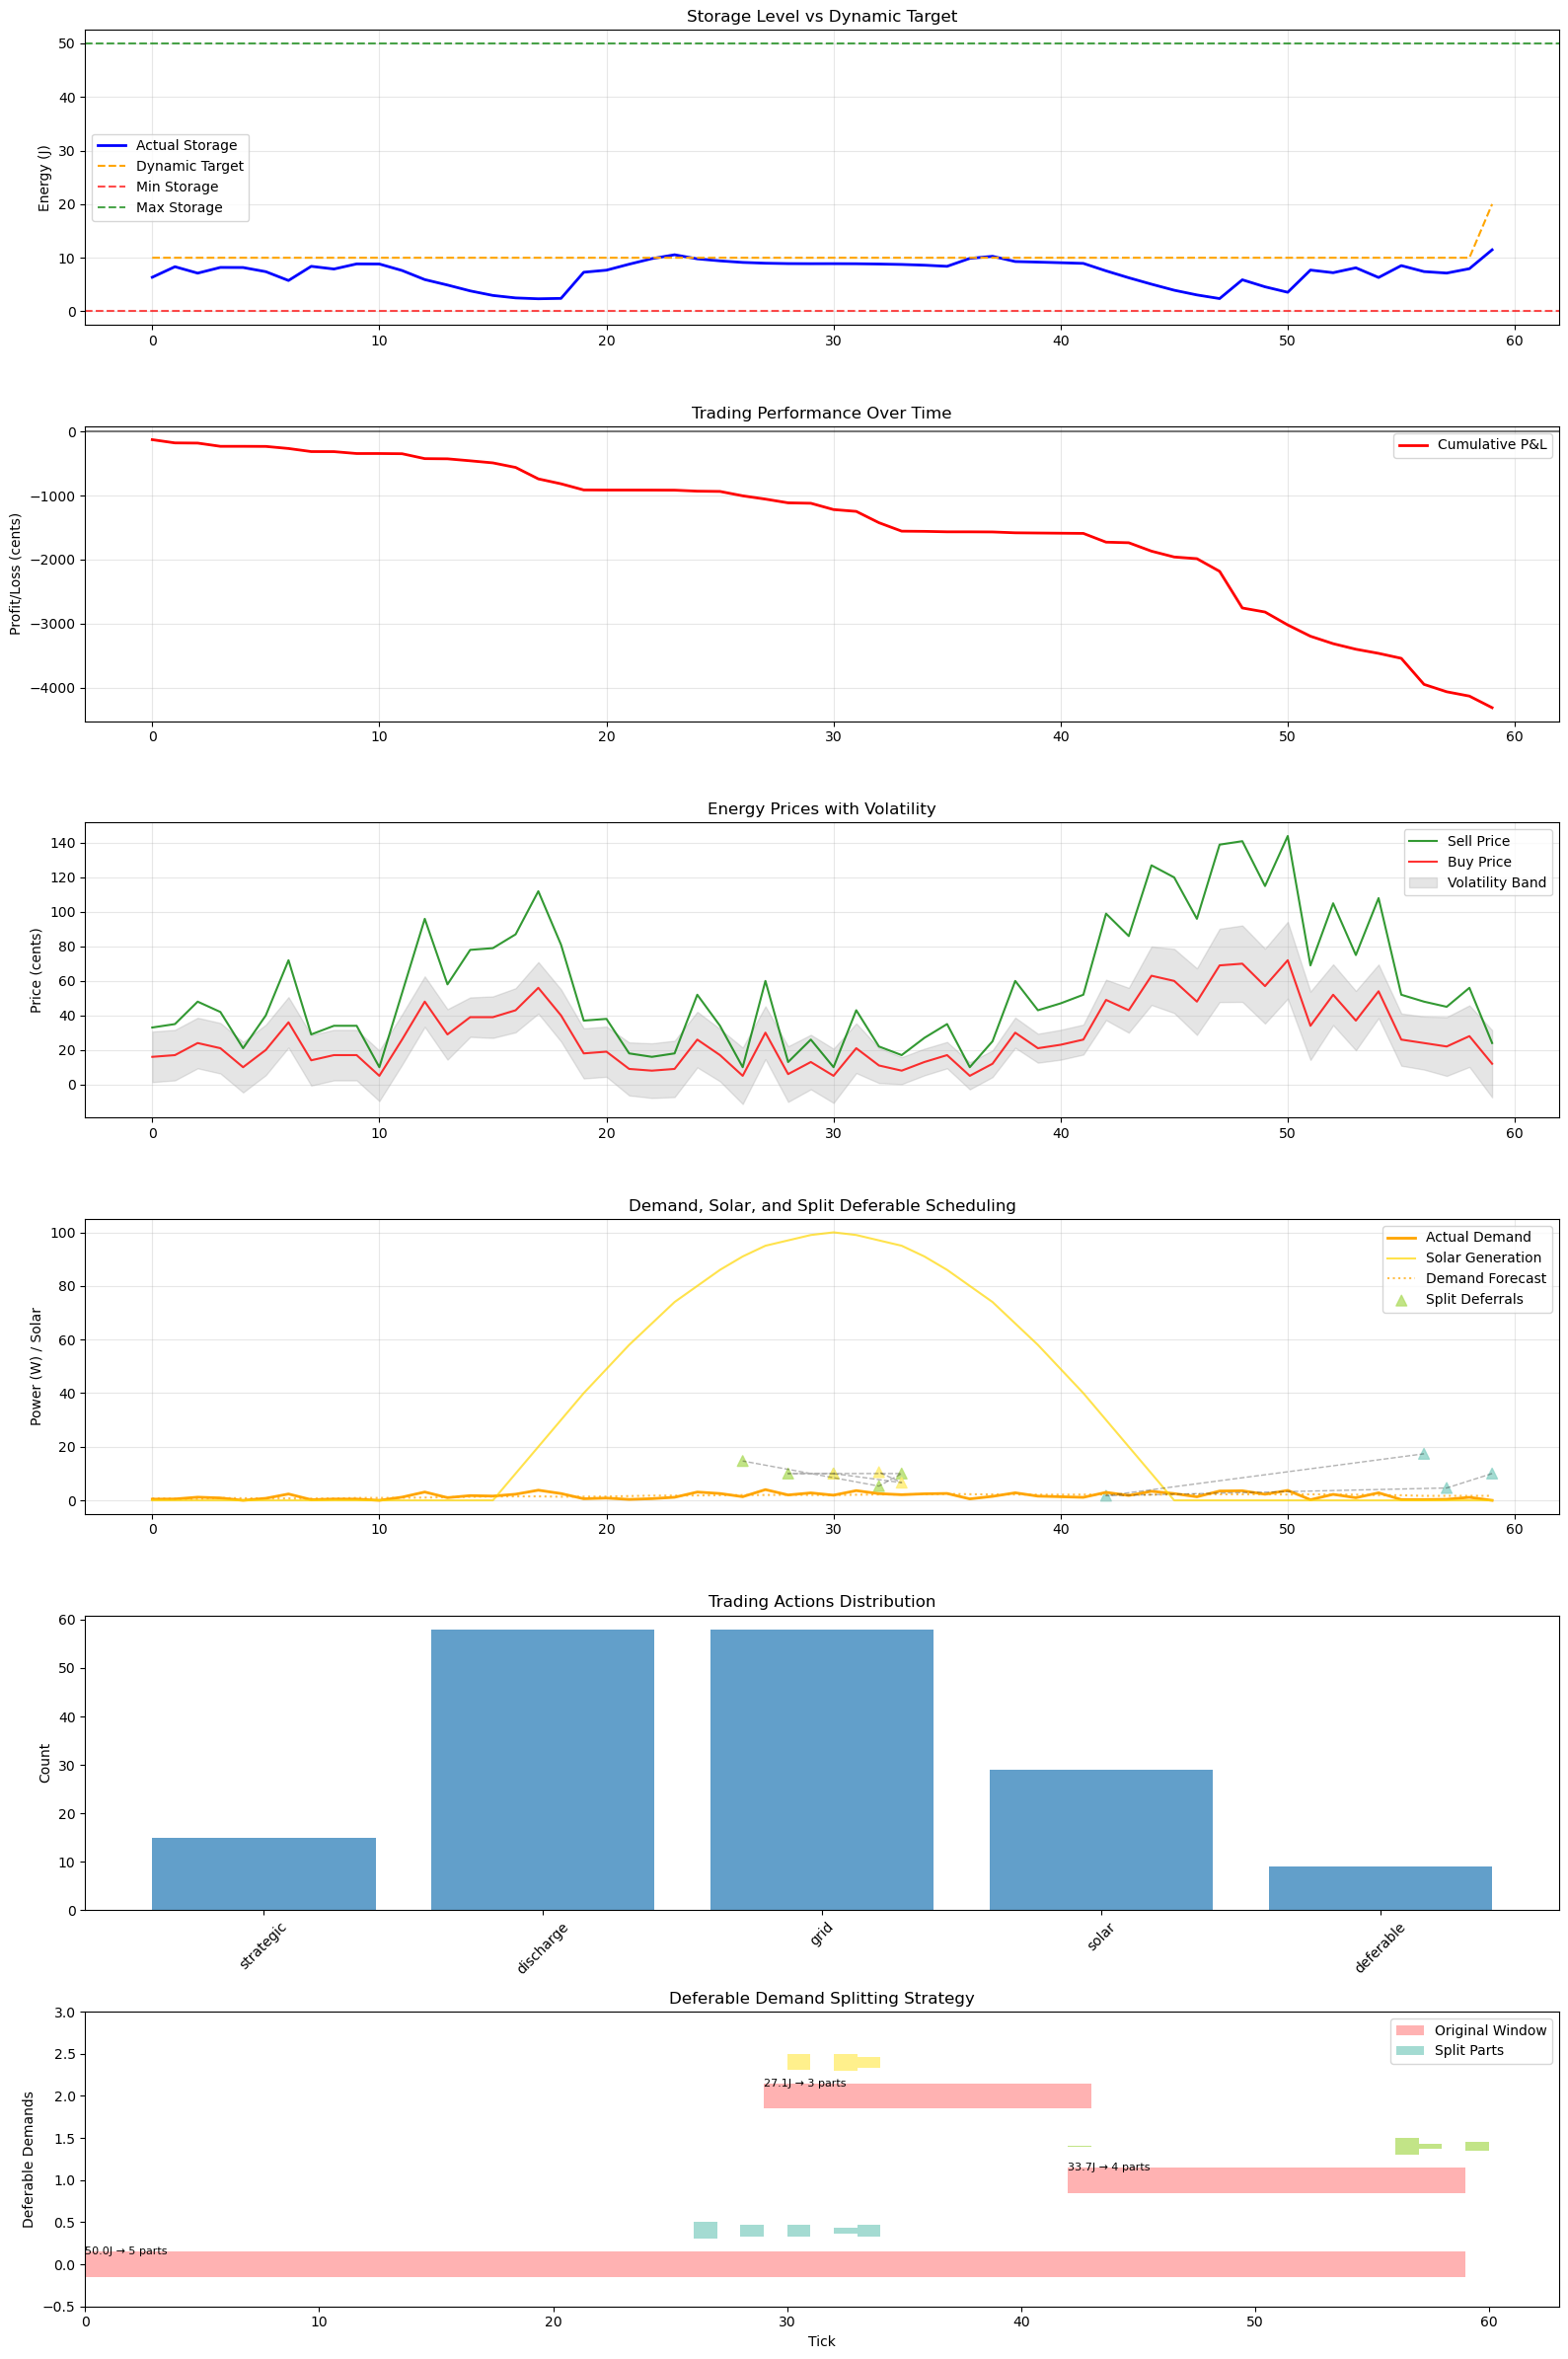


=== ENHANCED RESULTS ===
Final P&L: -4312.30 cents
Total loss minimized: 4312.30 cents
Final storage: 11.48 J
Storage utilization: 23.0%

Action Summary:
  deferable: 9
  discharge: 58
  grid: 58
  solar: 29
  strategic: 15

Deferable Demand Splitting Analysis:
  Original deferable demands: 3
  Total scheduled segments: 12
  Average splits per demand: 4.0
  Average timing shift: -0.4 ticks
  Demands moved earlier: 2
  Demands moved later: 1

Splitting Examples:
  Demand 1: 50.0J → 5 parts (['10.0W', '10.0W', '10.0W', '5.3W', '14.7W'])
  Demand 2: 33.7J → 4 parts (['10.0W', '4.6W', '1.7W', '17.4W'])
  Demand 3: 27.1J → 3 parts (['10.0W', '6.6W', '10.5W'])

Efficiency Metrics:
  Total energy traded: 324.15 J
  Loss per unit energy: 13.3034 cents/J


In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import math
from scipy.optimize import minimize_scalar

# Constants
MAX_STORAGE = 50
MIN_STORAGE = 0
CHARGE_TAU = 4
DISCHARGE_TAU = 4
DT = 1
SUNRISE = 15
DAY_LENGTH = 30

# Enhanced efficiency parameters
CHARGE_EFFICIENCY = 0.85
DISCHARGE_EFFICIENCY = 0.90
STORAGE_DECAY = 0.998

def fetch_data():
    """Fetch data from server with enhanced error handling"""
    BASE_URL = "https://icelec50015.azurewebsites.net"
    
    try:
        response = requests.get(f"{BASE_URL}/yesterday")
        if response.status_code != 200:
            print(f"Error: Server returned status code {response.status_code}")
            return None, None
            
        df = pd.DataFrame(response.json())
        
        # Add sun data
        df['sun'] = df['tick'].apply(lambda t: 
            int(math.sin((t-SUNRISE)*math.pi/DAY_LENGTH)*100) 
            if SUNRISE <= t < SUNRISE + DAY_LENGTH else 0
        )
        
        # Fetch deferable demands
        defer_response = requests.get(f"{BASE_URL}/deferables")
        if defer_response.status_code == 200:
            defer_data = defer_response.json()
            defer_df = pd.DataFrame(defer_data)
            
            if len(defer_df) > 0:
                print(f"Fetched {len(defer_df)} deferable demands")
                # Handle different possible column names
                if 'demand' not in defer_df.columns:
                    for alt_col in ['energy', 'amount', 'value']:
                        if alt_col in defer_df.columns:
                            defer_df['demand'] = defer_df[alt_col]
                            break
            else:
                defer_df = pd.DataFrame(columns=['start', 'end', 'demand'])
        else:
            defer_df = pd.DataFrame(columns=['start', 'end', 'demand'])
            
        return df, defer_df
        
    except requests.RequestException as e:
        print(f"Error connecting to server: {e}")
        return None, None

def enhanced_forecasting(df, window=15):
    """Advanced forecasting with multiple horizons and seasonality detection"""
    # Multi-horizon forecasting
    for horizon in [1, 3, 5, 10]:
        df[f'demand_forecast_{horizon}'] = (
            df['demand'].rolling(window, min_periods=1).mean().shift(-horizon)
        )
        df[f'buy_price_forecast_{horizon}'] = (
            df['buy_price'].rolling(window, min_periods=1).mean().shift(-horizon)
        )
        df[f'sell_price_forecast_{horizon}'] = (
            df['sell_price'].rolling(window, min_periods=1).mean().shift(-horizon)
        )
    
    # Price volatility indicators
    df['price_volatility'] = df['buy_price'].rolling(window).std()
    df['price_trend'] = df['buy_price'].rolling(window).apply(
        lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) >= 2 else 0
    )
    
    # Solar forecasting
    df['sun_forecast'] = df['sun'].shift(-3)  # 3-tick ahead solar forecast
    
    # Fill missing values
    forecast_cols = [col for col in df.columns if 'forecast' in col]
    for col in forecast_cols:
        df[col] = df[col].fillna(method='bfill').fillna(method='ffill')
    
    df['price_volatility'] = df['price_volatility'].fillna(df['price_volatility'].mean())
    df['price_trend'] = df['price_trend'].fillna(0)
    
    return df

def calculate_optimal_defer_schedule_split(defer_df, df, max_power_per_tick=10):
    """
    Advanced deferable demand scheduling with splitting capability
    Deferable demand is in Joules (total energy), can be split across multiple ticks
    Regular demand is in Watts (power per tick)
    """
    if len(defer_df) == 0:
        return []
    
    scheduled_deferrals = []
    
    for _, defer_row in defer_df.iterrows():
        try:
            start_tick = defer_row['start']
            end_tick = defer_row['end']
            total_energy_joules = defer_row['demand']  # Total energy in Joules
            
            window_df = df[(df['tick'] >= start_tick) & (df['tick'] <= end_tick)].copy()
            if len(window_df) == 0:
                continue
            
            # Calculate comprehensive score for each tick
            window_df['defer_score'] = (
                window_df['buy_price'] * 0.4 +  # Direct cost impact
                window_df.get('buy_price_forecast_3', window_df['buy_price']) * 0.15 +
                (100 - window_df['sun']) * 0.25 +  # Prefer high solar times
                (window_df['demand'] / max(window_df['demand'].max(), 1)) * 0.15 +  # Avoid high demand times
                window_df.get('price_volatility', 0) * 0.05
            )
            
            # Sort ticks by score (best first)
            window_df_sorted = window_df.sort_values('defer_score')
            
            # Determine optimal splitting strategy
            available_ticks = len(window_df_sorted)
            min_ticks_needed = max(1, int(np.ceil(total_energy_joules / max_power_per_tick)))
            
            # Choose number of ticks to spread across (balance efficiency vs. optimization)
            if total_energy_joules <= max_power_per_tick:
                # Small demand - use single best tick
                num_ticks = 1
            elif total_energy_joules <= max_power_per_tick * 3:
                # Medium demand - use 2-3 best ticks
                num_ticks = min(3, available_ticks, min_ticks_needed + 1)
            else:
                # Large demand - spread more but not too thin
                num_ticks = min(max(min_ticks_needed, 4), available_ticks, 8)
            
            selected_ticks = window_df_sorted.head(num_ticks)
            
            # Distribute energy across selected ticks
            # Weight distribution by inverse score (better ticks get more energy)
            scores = selected_ticks['defer_score'].values
            max_score = scores.max()
            weights = (max_score - scores + 0.1)  # Invert scores, add small constant
            weights = weights / weights.sum()  # Normalize
            
            # Distribute energy proportionally
            remaining_energy = total_energy_joules
            for idx, (_, tick_row) in enumerate(selected_ticks.iterrows()):
                if idx == len(selected_ticks) - 1:
                    # Last tick gets remaining energy
                    energy_this_tick = remaining_energy
                else:
                    # Distribute proportionally, but respect max power constraint
                    target_energy = total_energy_joules * weights[idx]
                    energy_this_tick = min(target_energy, max_power_per_tick, remaining_energy)
                
                if energy_this_tick > 0.1:  # Only schedule significant amounts
                    scheduled_deferrals.append({
                        'tick': tick_row['tick'],
                        'demand': energy_this_tick,  # Power in Watts for this tick
                        'original_start': start_tick,
                        'original_end': end_tick,
                        'total_original_energy': total_energy_joules,
                        'score': tick_row['defer_score'],
                        'split_part': f"{idx+1}/{len(selected_ticks)}"
                    })
                    
                    remaining_energy -= energy_this_tick
                    
                if remaining_energy <= 0.1:
                    break
            
        except Exception as e:
            print(f"Error processing deferable demand: {e}")
            continue
    
    return scheduled_deferrals

def calculate_storage_target(current_tick, df, horizon=10):
    """Calculate optimal storage target based on upcoming conditions"""
    future_slice = df[df['tick'] > current_tick].head(horizon)
    if len(future_slice) == 0:
        return MAX_STORAGE * 0.4
    
    # Calculate expected demand and solar in near future
    avg_demand = future_slice['demand'].mean()
    avg_solar = future_slice['sun'].mean()
    price_trend = future_slice['buy_price'].mean() - df['buy_price'].mean()
    
    # Base target on expected conditions
    base_target = avg_demand * 2
    
    # Adjust for solar availability
    if avg_solar > 50:
        base_target *= 0.7  # Less storage needed with good solar
    
    # Adjust for price trends
    if price_trend > 0:  # Prices rising
        base_target *= 1.2  # Store more now
    
    return min(max(base_target, MAX_STORAGE * 0.2), MAX_STORAGE * 0.8)

def run_enhanced_loss_minimizing_algorithm(df, defer_df, window=15):
    """Enhanced loss-minimizing algorithm with advanced strategies"""
    
    # Enhanced forecasting
    df = enhanced_forecasting(df, window)
    
    storage = [0]
    actions = []
    profit = 0
    profit_over_time = []
    
    # Advanced deferable demand scheduling with splitting
    scheduled_deferrals = calculate_optimal_defer_schedule_split(defer_df, df)
    defer_lookup = {}
    for defer_item in scheduled_deferrals:
        tick = defer_item['tick']
        if tick not in defer_lookup:
            defer_lookup[tick] = []
        defer_lookup[tick].append(defer_item)
    
    print(f"Scheduled {len(scheduled_deferrals)} deferable demand segments with splitting optimization")
    
    for i in range(len(df)):
        row = df.iloc[i]
        tick = row['tick']
        sell_price = row['sell_price']
        buy_price = row['buy_price']
        immediate_demand = row['demand']
        sun = row['sun']
        current_storage = storage[-1] * STORAGE_DECAY
        
        # Get deferable demands for this tick (now in Watts as power)
        deferable_power = 0  # Power demand in Watts for this tick
        if tick in defer_lookup:
            deferable_power = sum(d['demand'] for d in defer_lookup[tick])
            if deferable_power > 0:
                actions.append(f'deferable_{deferable_power:.2f}W')
        
        total_power_demand = immediate_demand + deferable_power  # Both in Watts
        
        # Calculate dynamic storage target
        storage_target = calculate_storage_target(tick, df)
        
        # 1. SOLAR CHARGING (prioritize free energy)
        if sun > 0:
            solar_energy = sun * 0.01 * 3
            charge_possible = (MAX_STORAGE - current_storage) * (1 - np.exp(-DT / CHARGE_TAU))
            actual_charge = min(solar_energy, charge_possible) * CHARGE_EFFICIENCY
            
            if actual_charge > 0.01:
                current_storage += actual_charge
                actions.append(f'solar_charge_{actual_charge:.2f}J')
        
        # 2. ADVANCED STRATEGIC BUYING
        # Buy conditions with multiple factors
        should_buy = False
        buy_amount = 0
        
        # Factor 1: Storage level vs target
        storage_deficit = max(0, storage_target - current_storage)
        
        # Factor 2: Price conditions
        price_threshold = row.get('buy_price_forecast_3', buy_price) * 1.03
        is_good_price = buy_price <= price_threshold
        
        # Factor 3: Upcoming demand (power in Watts)
        future_demand = row.get('demand_forecast_3', immediate_demand)
        demand_pressure = (future_demand + deferable_power) > current_storage * 0.8
        
        # Factor 4: Solar forecast
        future_solar = row.get('sun_forecast', 0)
        low_future_solar = future_solar < 30
        
        if (storage_deficit > 2 and is_good_price) or (demand_pressure and low_future_solar):
            should_buy = True
            buy_amount = min(
                storage_deficit * 0.8,
                8.0,  # Increased max buy
                MAX_STORAGE - current_storage
            )
        
        if should_buy and buy_amount > 0.1:
            energy_stored = buy_amount * CHARGE_EFFICIENCY
            current_storage += energy_stored
            profit -= buy_amount * buy_price
            actions.append(f'strategic_buy_{buy_amount:.2f}J')
        
        # 3. INTELLIGENT SELLING
        # Only sell when we have significant excess and good conditions
        excess_threshold = max(storage_target * 1.5, total_power_demand * 3)
        excess_storage = current_storage - excess_threshold
        
        # Enhanced selling conditions
        price_premium = sell_price / max(row.get('sell_price_forecast_3', sell_price), 0.01)
        is_premium_price = price_premium > 1.08
        low_solar_period = sun < 20
        
        if (excess_storage > 5 and is_premium_price and low_solar_period):
            sell_amount = min(
                excess_storage * 0.3,
                6.0,
                current_storage - storage_target
            )
            
            if sell_amount > 0.1:
                energy_sold = sell_amount * DISCHARGE_EFFICIENCY
                current_storage -= sell_amount
                profit += energy_sold * sell_price
                actions.append(f'intelligent_sell_{sell_amount:.2f}J')
        
        # 4. MEET DEMAND EFFICIENTLY (total_power_demand is in Watts)
        if total_power_demand > 0:
            # Prioritize stored energy usage
            discharge_possible = current_storage * (1 - np.exp(-DT / DISCHARGE_TAU))
            used_from_storage = min(total_power_demand, discharge_possible)
            
            if used_from_storage > 0.01:
                actual_energy_delivered = used_from_storage * DISCHARGE_EFFICIENCY
                current_storage -= used_from_storage
                actions.append(f'discharge_{used_from_storage:.2f}J')
                shortfall = total_power_demand - actual_energy_delivered
            else:
                shortfall = total_power_demand
            
            # Buy remaining from grid
            if shortfall > 0.01:
                profit -= shortfall * buy_price
                if deferable_power > 0:
                    actions.append(f'grid_buy_{shortfall:.2f}J_with_defer')
                else:
                    actions.append(f'grid_buy_{shortfall:.2f}J')
        
        # Update storage bounds
        current_storage = max(MIN_STORAGE, min(current_storage, MAX_STORAGE))
        storage.append(current_storage)
        profit_over_time.append(profit)
    
    return storage[1:], profit_over_time, actions, scheduled_deferrals

def plot_enhanced_results(df, storage, profit_over_time, actions, scheduled_deferrals):
    """Enhanced plotting with additional analytics"""
    fig, axes = plt.subplots(6, 1, figsize=(16, 24))
    
    # 1. Storage Level with Target
    axes[0].plot(df['tick'], storage, label='Actual Storage', color='blue', linewidth=2)
    
    # Calculate and plot storage targets
    targets = [calculate_storage_target(tick, df) for tick in df['tick']]
    axes[0].plot(df['tick'], targets, label='Dynamic Target', color='orange', linestyle='--')
    
    axes[0].axhline(y=MIN_STORAGE, color='r', linestyle='--', alpha=0.7, label='Min Storage')
    axes[0].axhline(y=MAX_STORAGE, color='g', linestyle='--', alpha=0.7, label='Max Storage')
    axes[0].set_title('Storage Level vs Dynamic Target')
    axes[0].set_ylabel('Energy (J)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 2. Profit/Loss Analysis
    axes[1].plot(df['tick'], profit_over_time, color='red', linewidth=2, label='Cumulative P&L')
    axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    axes[1].set_title('Trading Performance Over Time')
    axes[1].set_ylabel('Profit/Loss (cents)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # 3. Price Analysis with Volatility
    axes[2].plot(df['tick'], df['sell_price'], label='Sell Price', color='green', alpha=0.8)
    axes[2].plot(df['tick'], df['buy_price'], label='Buy Price', color='red', alpha=0.8)
    
    # Add volatility bands
    if 'price_volatility' in df.columns:
        volatility = df['price_volatility'].fillna(0)
        axes[2].fill_between(df['tick'], 
                           df['buy_price'] - volatility, 
                           df['buy_price'] + volatility, 
                           alpha=0.2, color='gray', label='Volatility Band')
    
    axes[2].set_title('Energy Prices with Volatility')
    axes[2].set_ylabel('Price (cents)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    # 4. Demand and Solar with Forecasts
    axes[3].plot(df['tick'], df['demand'], label='Actual Demand', color='orange', linewidth=2)
    axes[3].plot(df['tick'], df['sun'], label='Solar Generation', color='gold', alpha=0.7)
    
    if 'demand_forecast_3' in df.columns:
        axes[3].plot(df['tick'], df['demand_forecast_3'], 
                    label='Demand Forecast', color='orange', linestyle=':', alpha=0.7)
    
    # Add scheduled deferrals with splitting visualization
    if scheduled_deferrals:
        defer_ticks = [d['tick'] for d in scheduled_deferrals]
        defer_powers = [d['demand'] for d in scheduled_deferrals]  # Now in Watts
        
        # Color code by original deferable demand
        colors = plt.cm.Set3(np.linspace(0, 1, len(set(d['total_original_energy'] for d in scheduled_deferrals))))
        color_map = {energy: color for energy, color in zip(
            set(d['total_original_energy'] for d in scheduled_deferrals), colors)}
        
        scatter_colors = [color_map[d['total_original_energy']] for d in scheduled_deferrals]
        
        axes[3].scatter(defer_ticks, defer_powers, c=scatter_colors, s=60, 
                       label='Split Deferrals', alpha=0.8, marker='^')
        
        # Add lines connecting split parts of same original demand
        original_demands = {}
        for d in scheduled_deferrals:
            key = (d['original_start'], d['original_end'], d['total_original_energy'])
            if key not in original_demands:
                original_demands[key] = []
            original_demands[key].append(d)
        
        for parts in original_demands.values():
            if len(parts) > 1:
                ticks = [p['tick'] for p in parts]
                powers = [p['demand'] for p in parts]
                axes[3].plot(ticks, powers, 'k--', alpha=0.3, linewidth=1)
    
    axes[3].set_title('Demand, Solar, and Split Deferable Scheduling')
    axes[3].set_ylabel('Power (W) / Solar')
    axes[3].legend()
    axes[3].grid(True, alpha=0.3)
    
    # 5. Action Analysis
    action_types = {}
    for action in actions:
        action_type = action.split('_')[0]
        if action_type not in action_types:
            action_types[action_type] = 0
        action_types[action_type] += 1
    
    if action_types:
        axes[4].bar(action_types.keys(), action_types.values(), alpha=0.7)
        axes[4].set_title('Trading Actions Distribution')
        axes[4].set_ylabel('Count')
        axes[4].tick_params(axis='x', rotation=45)
    
    # 6. Deferable Demand Splitting Visualization
    if scheduled_deferrals:
        # Group by original deferable demand
        original_demands = {}
        for d in scheduled_deferrals:
            key = (d['original_start'], d['original_end'], d['total_original_energy'])
            if key not in original_demands:
                original_demands[key] = []
            original_demands[key].append(d)
        
        y_pos = 0
        colors = plt.cm.Set3(np.linspace(0, 1, len(original_demands)))
        
        for i, (key, parts) in enumerate(original_demands.items()):
            original_start, original_end, total_energy = key
            
            # Show original as a bar
            axes[5].barh(y_pos, original_end - original_start, left=original_start, 
                        height=0.3, alpha=0.3, color='red', 
                        label='Original Window' if i == 0 else "")
            
            # Show splits as individual bars
            for j, part in enumerate(parts):
                axes[5].barh(y_pos + 0.4, 1, left=part['tick'], 
                           height=part['demand'] / max(p['demand'] for p in parts) * 0.2,
                           color=colors[i], alpha=0.8,
                           label=f'Split Parts' if i == 0 and j == 0 else "")
            
            # Add text annotation
            axes[5].text(original_start, y_pos + 0.15, 
                        f'{total_energy:.1f}J → {len(parts)} parts', 
                        fontsize=8, va='center')
            
            y_pos += 1
        
        axes[5].set_ylim(-0.5, y_pos)
        axes[5].set_title('Deferable Demand Splitting Strategy')
        axes[5].set_xlabel('Tick')
        axes[5].set_ylabel('Deferable Demands')
        axes[5].legend()
    else:
        axes[5].text(0.5, 0.5, 'No Deferable Demands to Split', 
                    ha='center', va='center', transform=axes[5].transAxes)
    
    plt.tight_layout()
    plt.show()

def main():
    """Enhanced main function with detailed analytics"""
    df, defer_df = fetch_data()
    if df is None:
        return
    
    print(f"Loaded {len(df)} main data points")
    print(f"Loaded {len(defer_df)} deferable demands")
    
    # Run enhanced algorithm
    storage, profit, actions, scheduled_deferrals = run_enhanced_loss_minimizing_algorithm(df, defer_df)
    
    # Plot results
    plot_enhanced_results(df, storage, profit, actions, scheduled_deferrals)
    
    # Detailed analysis
    final_profit_loss = profit[-1]
    final_loss = abs(min(0, final_profit_loss))
    
    print(f"\n=== ENHANCED RESULTS ===")
    print(f"Final P&L: {final_profit_loss:.2f} cents")
    print(f"Total loss minimized: {final_loss:.2f} cents")
    print(f"Final storage: {storage[-1]:.2f} J")
    print(f"Storage utilization: {(storage[-1]/MAX_STORAGE)*100:.1f}%")
    
    # Action breakdown
    action_counts = {}
    for action in actions:
        action_type = action.split('_')[0]
        action_counts[action_type] = action_counts.get(action_type, 0) + 1
    
    print(f"\nAction Summary:")
    for action_type, count in sorted(action_counts.items()):
        print(f"  {action_type}: {count}")
    
    # Deferable demand analysis with splitting
    if scheduled_deferrals:
        # Group by original demands to analyze splitting
        original_demands = {}
        for d in scheduled_deferrals:
            key = (d['original_start'], d['original_end'], d['total_original_energy'])
            if key not in original_demands:
                original_demands[key] = []
            original_demands[key].append(d)
        
        total_original_demands = len(original_demands)
        total_splits = len(scheduled_deferrals)
        avg_splits_per_demand = total_splits / total_original_demands if total_original_demands > 0 else 0
        
        print(f"\nDeferable Demand Splitting Analysis:")
        print(f"  Original deferable demands: {total_original_demands}")
        print(f"  Total scheduled segments: {total_splits}")
        print(f"  Average splits per demand: {avg_splits_per_demand:.1f}")
        
        # Analyze timing optimization
        timing_improvements = []
        for key, parts in original_demands.items():
            original_start, original_end, total_energy = key
            original_mid = (original_start + original_end) / 2
            
            # Calculate weighted average scheduled time
            total_power = sum(p['demand'] for p in parts)
            weighted_scheduled_time = sum(p['tick'] * p['demand'] for p in parts) / total_power
            timing_improvement = original_mid - weighted_scheduled_time
            timing_improvements.append(timing_improvement)
        
        if timing_improvements:
            avg_timing_shift = np.mean(timing_improvements)
            print(f"  Average timing shift: {avg_timing_shift:.1f} ticks")
            print(f"  Demands moved earlier: {sum(1 for t in timing_improvements if t > 0)}")
            print(f"  Demands moved later: {sum(1 for t in timing_improvements if t < 0)}")
            
        # Show splitting examples
        print(f"\nSplitting Examples:")
        for i, (key, parts) in enumerate(list(original_demands.items())[:3]):
            _, _, total_energy = key
            demand_strs = [f"{p['demand']:.1f}W" for p in parts]
            print(f"  Demand {i+1}: {total_energy:.1f}J → {len(parts)} parts ({demand_strs})")
    
    # Efficiency metrics
    def extract_energy(action):
        parts = action.split('_')
        # Handle patterns like 'buy_0.70J' and 'buy_defer_50.00J'
        for part in reversed(parts):
            try:
                return float(part.replace('J', ''))
            except ValueError:
                continue
        return 0.0

    total_energy_traded = sum(
        extract_energy(a)
        for a in actions
        if any(x in a for x in ['buy', 'sell', 'charge', 'discharge'])
    )
    if total_energy_traded > 0:
        loss_per_unit = final_loss / total_energy_traded
        print(f"\nEfficiency Metrics:")
        print(f"  Total energy traded: {total_energy_traded:.2f} J")
        print(f"  Loss per unit energy: {loss_per_unit:.4f} cents/J")

if __name__ == "__main__":
    main()

Final profit: -1152.81 cents
Peak storage: 49.7J
Total actions: 94


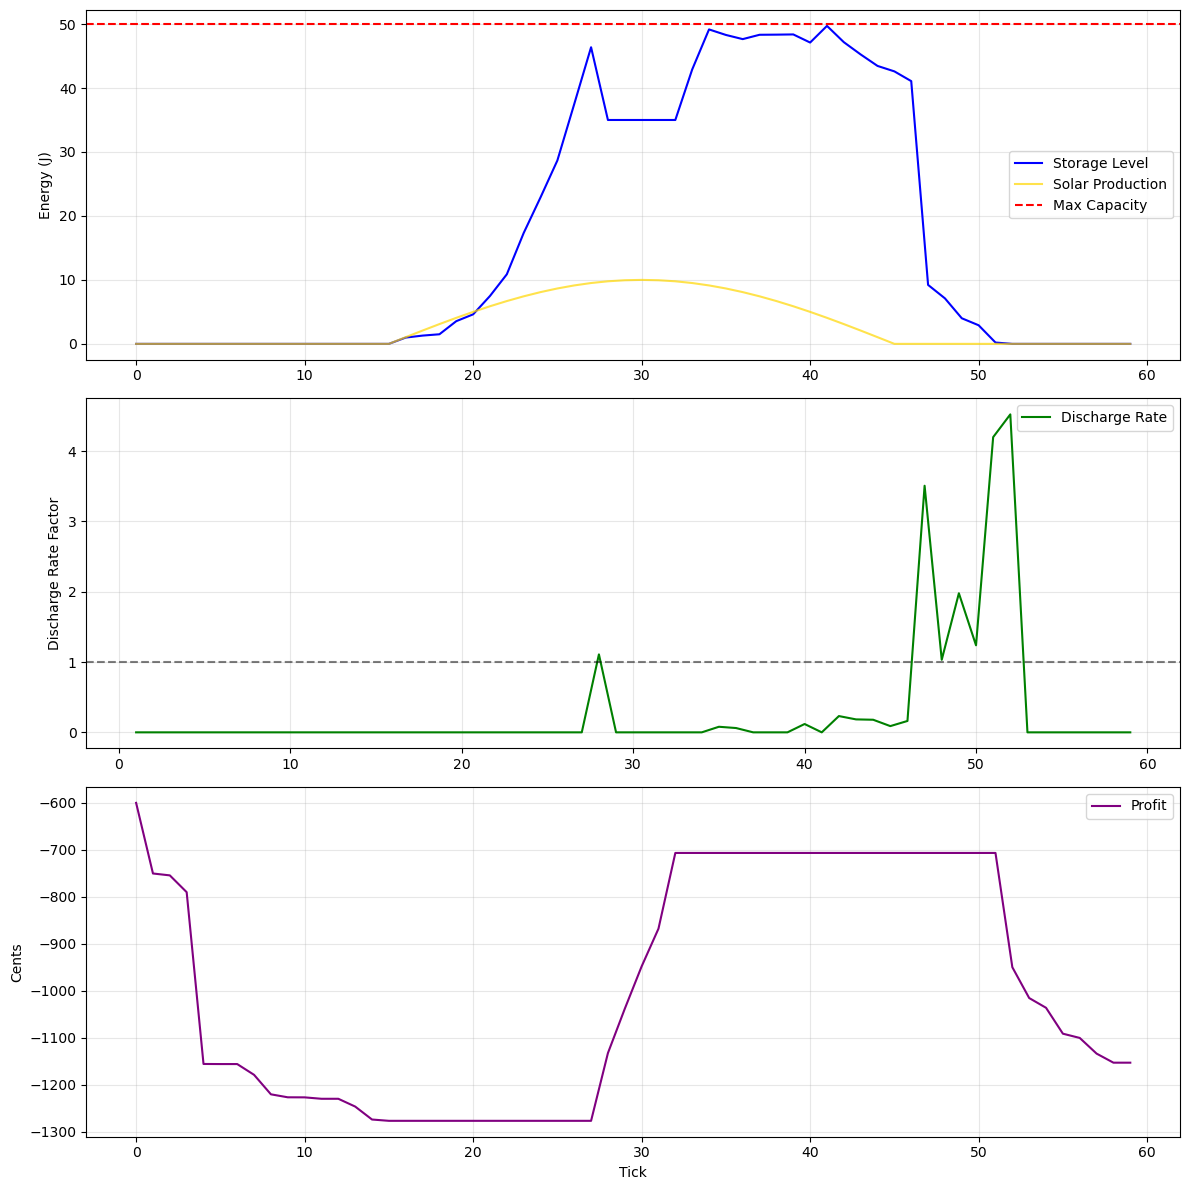

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import requests

# Constants
MAX_STORAGE = 50
MIN_STORAGE = 0
SUNRISE = 15
DAY_LENGTH = 30
SOLAR_SCALING = 10
CHARGE_TAU = 3.5  # Time constant for charging (ticks)
DISCHARGE_TAU = 4.0  # Time constant for discharging (ticks)
DT = 1  # Time step (1 tick)

def capacitor_charge(current, target, tau):
    """Models capacitor charging behavior"""
    return target - (target - current) * math.exp(-DT/tau)

def capacitor_discharge(current, tau):
    """Models capacitor discharging behavior"""
    return current * math.exp(-DT/tau)

def run_optimized_algorithm(df, defer_df):
    storage = [0]
    profit_history = [0]
    actions = []
    
    df['solar'] = df['tick'].apply(calculate_production)
    
    for i, row in df.iterrows():
        tick = row['tick']
        current_storage = storage[-1]
        solar = row['solar']
        demand = row['demand']
        sell_price = row['sell_price']
        buy_price = sell_price * 0.5
        
        # 1. SOLAR CHARGING (capacitor behavior)
        if solar > 0:
            charge_possible = MAX_STORAGE - current_storage
            target_charge = current_storage + solar
            new_storage = capacitor_charge(current_storage, target_charge, CHARGE_TAU)
            actual_charge = min(new_storage - current_storage, charge_possible)
            
            if actual_charge > 0.01:  # Threshold to avoid tiny charges
                current_storage += actual_charge
                actions.append(f"charge_{actual_charge:.2f}J")
        
        # 2. DEMAND PHASE (capacitor discharge)
        if demand > 0:
            # Calculate available energy using discharge equation
            available_energy = current_storage - capacitor_discharge(current_storage, DISCHARGE_TAU)
            discharge_amount = min(demand, available_energy)
            
            current_storage -= discharge_amount
            remaining_demand = demand - discharge_amount
            
            if discharge_amount > 0.01:
                actions.append(f"discharge_{discharge_amount:.2f}J")
            if remaining_demand > 0.01:
                profit_history[-1] -= remaining_demand * buy_price
                actions.append(f"buy_{remaining_demand:.2f}J")
        
        # 3. DEFERRABLE DEMANDS (with capacitor discharge)
        active_deferrables = defer_df[defer_df['start'] == tick]
        for _, defer in active_deferrables.iterrows():
            defer_energy = defer['energy']
            available_energy = current_storage - capacitor_discharge(current_storage, DISCHARGE_TAU)
            defer_discharge = min(defer_energy, available_energy)
            
            current_storage -= defer_discharge
            remaining_defer = defer_energy - defer_discharge
            
            if defer_discharge > 0.01:
                actions.append(f"discharge_defer_{defer_discharge:.2f}J")
            if remaining_defer > 0.01:
                profit_history[-1] -= remaining_defer * buy_price
                actions.append(f"buy_defer_{remaining_defer:.2f}J")
        
        # 4. SELL EXCESS (with charge/discharge constraints)
        if (SUNRISE + DAY_LENGTH//2 - 2 <= tick <= SUNRISE + DAY_LENGTH//2 + 2):
            available_energy = current_storage - capacitor_discharge(current_storage, DISCHARGE_TAU)
            excess = available_energy - MAX_STORAGE * 0.7
            
            if excess > 0.01:
                sell_amount = min(excess, MAX_STORAGE * 0.3)
                current_storage -= sell_amount
                profit_history[-1] += sell_amount * sell_price
                actions.append(f"sell_{sell_amount:.2f}J@{sell_price:.2f}c")
        
        storage.append(current_storage)
        profit_history.append(profit_history[-1])  # Carry forward
    
    return storage[1:], profit_history[1:], actions

# (Keep all other functions the same as in your original code)

def plot_results(df, storage, profit_history):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
    
    # 1. Storage and Solar
    ax1.plot(df['tick'], storage, label='Storage Level', color='blue')
    ax1.plot(df['tick'], df['solar'], label='Solar Production', color='gold', alpha=0.7)
    ax1.axhline(MAX_STORAGE, c='r', ls='--', label='Max Capacity')
    ax1.set_ylabel('Energy (J)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Discharge Analysis
    discharge_rates = []
    for i in range(1, len(storage)):
        if storage[i] < storage[i-1]:
            rate = (storage[i-1] - storage[i]) / (storage[i-1] * (1 - math.exp(-DT/DISCHARGE_TAU)))
            discharge_rates.append(rate)
        else:
            discharge_rates.append(0)
    
    ax2.plot(df['tick'][1:], discharge_rates, label='Discharge Rate', color='green')
    ax2.axhline(1, color='k', linestyle='--', alpha=0.5)
    ax2.set_ylabel('Discharge Rate Factor')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Profit
    ax3.plot(df['tick'], profit_history, label='Profit', color='purple')
    ax3.set_xlabel('Tick')
    ax3.set_ylabel('Cents')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Fetch data
    df, defer_df = fetch_data()
    if df is None:
        print("Failed to fetch data")
    else:
        # Run algorithm
        storage, profit_history, actions = run_solar_optimized_algorithm(df, defer_df)
        
        # Print summary
        print(f"Final profit: {profit_history[-1]:.2f} cents")
        print(f"Peak storage: {max(storage):.1f}J")
        print(f"Total actions: {len(actions)}")
        
        # Plot results
        plot_results(df, storage, profit_history)